# **AutoEncoders and hidden states Analysis**

Привет, друзья!
В этом домашнем задании вы разберетесь с идеей применения автокодировщиков для анализа и извлечения признаков из скрытых состояний модели.

За время выполнения домашнего задания, вы:

- Изучите или повторите, как работает извлечение признаков в Visual Transformers;
- Построите и примените автокодировщик для сжатия скрытых представлений, выученных моделью ViT в задаче классификации котиков и собачек;
- Сравните Vit и PCA в задаче извлечения признаков.

Приступим!

In [ ]:
# Как всегда начнем работу с импорта нужных библиотек
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import random
import requests
import os
import seaborn as sns
from io import BytesIO
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
torch.manual_seed(7)
torch.cuda.manual_seed(7)
np.random.seed(7)
random.seed(7)

Загрузим и откроем изображение.

In [ ]:
# Загрузка изображения
IMG_PATH = 'https://github.com/SadSabrina/explainable_AI_course/blob/main/HW_module15_hidden_representations/chester.jpg?raw=true'
image_bytes = requests.get(IMG_PATH).content
image = Image.open(BytesIO(image_bytes))

plt.imshow(image)
plt.axis('off');
plt.show()

Чтобы было визуально приятнее работать, обрежем и развернем картинку.

In [ ]:
#Решим проблему с поворотом
def rotate_PIL (image, angel, interpolation):
    #PIL.Image.NEAREST (use nearest neighbour), PIL.Image.BILINEAR (linear interpolation in a 2×2 environment), or PIL.Image.BICUBIC
    return image.rotate(angel, interpolation)

image = image.crop((500, 0, 4000, 3000))
image = rotate_PIL(image, -90, Image.BICUBIC)

In [ ]:
plt.imshow(np.array(image))
plt.axis('off')
plt.show()

Отлично, картинку мы загрузили и привели в чувства.

Теперь загрузим модель. Вы можете загрузить модель с HF — такой вариант уже указан в коде. В случае если не выйдет, вам нужно:
1. скачать папку `cat_dog_model` по [ссылке](https://drive.google.com/drive/folders/1TztlM4sC0HRJmhZyMltRIGZP1exGRHt5?usp=sharing);
2.  указать папку с файлами в `MODEL_PATH`
3. выполнить загрузку.

In [ ]:
# Модель взята здесь: https://huggingface.co/akahana/vit-base-cats-vs-dogs
#MODEL_PATH = 'ВАШ_ПУТЬ_К_ПАПКЕ'

MODEL_PATH_HF = 'akahana/vit-base-cats-vs-dogs'

# Загружаем предобученный feature extractor и классификационную модель
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(MODEL_PATH_HF)

model.eval();

# **Подробнее о ViT**

Прежде чем перейти к построению автоэнкодера, анализу скрытых представлений или любой другой задаче, касающейся анализа модели, необходимо понять с чем мы будем работать, какие признаки будут у нас на входе и на каком этапе они извлекаются из сети.  


### **1. Признаки.**

При анализе векторных представлений текста, представленного токенами, в уроке про зондирование модели, ворма скрытых состояний для текстов была такой: `(batch_size, sequence_length, hidden_dim)`. То есть, для одного предложения из 6 токенов размерности были `(1, 6, 1024)` — 6 токенов, каждый представлен 1024-мерным вектором.

Получается, что, при работе с текстом, мы работаем с 1D векторами токенов какой-то фиксированной длины. И в целом, нам удобно сразу применять к ним сжимающией преобразования, например PCA. Но что насчет изображений? Рассмотрим, как прдеставляется картинка в ViT.

### **Изображения в признаки. Идея патчей**

Интуитивный и базовый подход представления изображения в виде, удобном для анализа и векторизации — взять изображение и сгладить его до 1D. Тогда, если изображение у нас 8x8 — всё хорошо, и при сглаживании получится вектор длины 64.

Однако, такой подход не оказывается рабочим, когд изображение чуть больше, скажем 64x64. Тогда его размерность в 1D уже 4096 и при этом каждый пиксель нужно будет связать с другим (то есть $4096^2$ связей).

И так, собирая то, что нам не нравится и некоторые аналогии из представления текстовых последовательностей, получается, что мы хотим:
- Чтобы каждое изображение отражали несколько векторов;
- Чтобы каждый из векторов был фиксированной и адекватной (заданной нами) размерности;

**Патчи в ViT.**

В ViT (Visual Transformers) — одной из значимых архитектур 2021([статья](https://arxiv.org/abs/2010.11929)) решение этих задач реализовано при помощи патчей.

Патчи строятся так:

1. Берем картинку $H, W, C$ – высота, ширина, число каналов  (1)
2. Режем её на $N$ патчей. Каждый из патчей — это "квадрат" на изображении, с размерностями $p, p, c$, где $p$ — сторона квадрата (2)
3. Эти патчи разглаживаем  в вектор, выходит N векторов размерностью $p^2*C$ (3)
4. Массив патчей, размерностью $(N, p^2*C)$ умножается на обучаемый тензор
с размерностями  $(p^2*C, d)$  (4)
5. В результате получаем N патчей с размерностями $(1, d)$  (5)
6. Добавляем $[cls]$ токен, аналогичный BERT (картинка и интуитивный ответ [тут](https://stackoverflow.com/questions/62705268/why-bert-transformer-uses-cls-token-for-classification-instead-of-average-over), с размерностью $(1, d)$, итого у нас вход – $(N+1, d)$ патчей6)
6. В завершение каждому патчу добавляем позиционный эмбеддинг с такой-же размерностью $(1, d)$ (7)

И вот мы сварили признаки, которые далее проходят в слои энкодера.


![patches](https://user-images.githubusercontent.com/42609155/128160932-6c92920e-b996-4208-9f71-c5caeb4d7285.png)


**Сколько векторов на практике отражает изображение и какова их размерность?**

Размерность вектора параметров (то есть d в нотации выше) Vit — это фиксированный параметр. Стандартно, вектор имеет длину 768, таким образом, если входное изображение состоит из 1 канала и имеет размерности $(h, w) = (224, 224)$, то чтобы посчитать, сколько векторов будет его характеризовать, нужно выбрать:

1. Количество патчей для разбиения, $k$
2. Размер патчей, $p$

Количество и размер выбираем так, что $h=w=p\cdot k$. Тогда если патчей 14, как в примере, то количество векторов для кодирования изображения:

$$cnt = \frac{h}{p}*\frac{w}{p} = p * p = 14 * 14 = 196$$

Разбиение изображения осуществляется при помощи свертки с ядром $kernel=(p, p)$ и шагом (stride), таким что $stride=(p, p)$.

И вот, наше изображение будет представлено $197$ векторами ($196$ на патчи, плюс cls) размерностью $768$!



**Задание 1. Пусть входная картинка имеет размеры 168*168 и количество патчей равно 12. Чему равно количество векторов для кодирования изображения? Не забудьте про [CLS].**

Ответ: **Ваш ответ здесь**

### **2. Анализ структуры**

Теперь, прежде чем извлекать признаки, пусть мы уже знаем их размеры, нужно понять, откуда они будут вытащены. Для этого посмотрим на структуру модели.

Реализовывать само извлечение вручную нам не придется, поскольку скрытые состояния могут быть получены при помощи указании гиперпараметра при инференсе.

**Задание 2. Вызовите атрибут ._modules у модели. Сколько модулей верхнего уровня вам удалось обнаружить?**

In [ ]:
# Ваш код здесь

**Задание 3. Теперь, последовательно извлекая части из первой компоненты, которую вы нашли в задание выше, ответьте, сколько в модели слоёв `layer` в компоненте encoder'a ?**

In [ ]:
# Ваш код здесь

Зафиксируем, что основная модель состоит из последовательности энкодеров и классификатора. Теперь проанализируем, что будут представлять собой hidden states.

В библиотеке transformers возвращение скрытых состояний можно получить при помощи простого атрибута при инференсе.

Синтаксис примерно такой:



```
model = Net()
outputs = model(**inputs, output_hidden_states=True)

```


Проделаем извлечение признаков на одном примере. Для этого:
1. Пребразуем входную картинку в признаки при помощи `ViTImageProcessor`;
2. Пропустим полученное изображение через модель;
3. Рассмотрим полученные hidden states.

In [ ]:
# Подготавливаем входные данные
inputs = feature_extractor(images=image, return_tensors="pt", do_convert_rgb=True, do_normalize=False)

# Посмотрим, в каком виде изображение будет пропущено через модель
featured_image = inputs['pixel_values'][0].permute(1, 2, 0)

fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(featured_image)
plt.axis('off');

Теперь выполним прогноз.

In [ ]:
# Делаем предсказание
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

# Получаем спрогнозированный класс
predicted_class_idx = torch.sigmoid(outputs.logits).argmax(-1).item()
labels = model.config.id2label  # Словарь индексов и классов

print(f"Предсказанный класс: {labels[predicted_class_idx]}")

**Задание 4. Проанализируйте вероятности классов, выданные моделью. На сколько класс `dog` превысил класс `cat`? Ответ не округляйте — запишите все цифры.**

In [ ]:
torch.sigmoid(outputs.logits)

In [ ]:
0.5887 - 0.4255

In [ ]:
print(f'Количество скрытых состояний: {len(outputs.hidden_states)}')
print(f'Размерность каждого состояния: {outputs.hidden_states[0].shape}')

Ура-ура! Хоть и с неверным прогнозом, но мы всё извлекли. Количество скрытых состояний равно 13, где

* Первое ('outputs.hidden_states[0]') — выход части эмбеддинга `model.vit.embeddings`
* Состояния 2-13 — выходы частей энкодера — все до применения к ним самого последнего слоя компоненты `model.vit` — `layernorm`

**Важно:**

В некоторых моделях, при указании `output_hidden_states=True` возвращается также `last_hidden_state`. В общем случае, `outputs.last_hidden_state != outputs.hidden_states[-1]`, так как то, что хранится в  `outputs.last_hidden_state` отражает скрытое состояние после `layernorm`

Теперь, поняв выход для одной картинки, мы можем прогнать несколько. Скажем 300 котиков и собачек — они будут гнаться примерно 5 минут. Для выполнения, вы можете скачать данные с диска [здесь](https://drive.google.com/drive/folders/1TztlM4sC0HRJmhZyMltRIGZP1exGRHt5?usp=sharing).

In [ ]:
# Указываем путь к папке с изображениями
image_folder = "ВАШ_ПУТЬ_К_ПАПКЕ test_cats_dogs"


# Подготавливаем списки для данных
last_hidden_states_list = []
mid_hidden_states_list = []
labels_list = []
probas_list = []

images_list = os.listdir(image_folder)
images_sample = random.sample(images_list, 300)

# Проходим по всем файлам в папке
for filename in tqdm(os.listdir(image_folder)[:300]):
    if filename.endswith((".jpg", ".png", ".jpeg")):  # Фильтруем изображения
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert("RGB")  # Открываем изображение

        # Обрабатываем изображение с помощью feature extractor
        inputs = feature_extractor(images=image, return_tensors="pt")

        # Получаем скрытые состояния
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            features = model.vit(**inputs).last_hidden_state[:, 1:, :] # представление изображения перед подачей в классификатор
            mid_features = outputs.hidden_states[len(outputs.hidden_states) // 2][:, 1:, :]  # Последний слой (размерность: batch x patches x hidden_dim)

        predicted_class_idx = outputs.logits.argmax(-1).item()
        predicted_probas = torch.sigmoid(outputs.logits)
        predicted_class_proba = predicted_probas.max().item()

        labels = model.config.id2label  # Словарь индексов и классов
        label = labels[predicted_class_idx]

        # Добавляем скрытые состояния и метку в список
        last_hidden_states_list.append(features.squeeze(0))  # Убираем batch размерность
        mid_hidden_states_list.append(mid_features.squeeze(0))
        labels_list.append(label)
        probas_list.append(predicted_class_proba)



In [ ]:
# Преобразуем в тензоры
last_hidden_states_tensor = torch.stack(last_hidden_states_list)  # Размерность: (num_images, hidden_dim)

mid_hidden_states_tensor = torch.stack(mid_hidden_states_list)

Теперь, подытожим, что мы имеем. На каждую картинку из 1000 у нас есть матрица $197$x$768$. В таком формате анализировать признаки и как-то разделить их для двух классов не удобно.  Как понять, разделила ли модель классы в пространстве?

Для этого мы можем применить автокодировщик!


## **Автокодировщик**

Напомню, что простейший автокодировщик выглядит так:

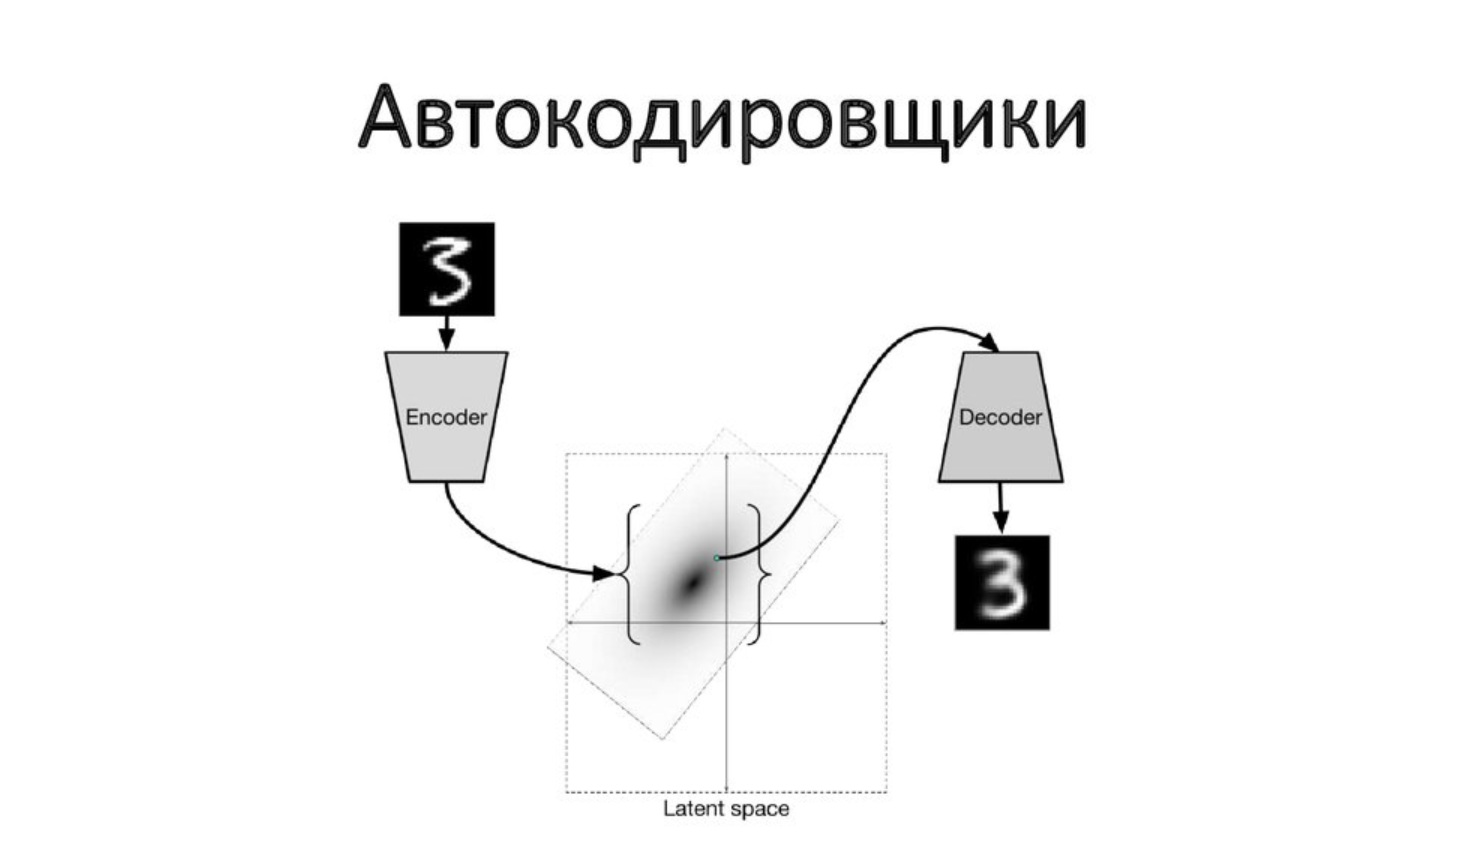

 Реализуем его в коде в виде двух компонент, как на картинке — энкодера и декодера. Для них напишем простые классы из такой логики:

 * У нас 196 патчей по 768 признаков, поскольку CLS представление не извлекалось. Такую структуру можно рассмотреть как матрицу, а значит по ней можно пройтись сверткой.

* Свернуть исходное изображение нам нужно к виду, который удобно представить. Лучший формат — на каждое исходное изображение оставить два признака.

**Для достижения задачи представления каждой картинки в виде вектора из двух чисел, можно пойти несколькими способами:**

1. Оставить число патчей как есть, поскольку каждая группа из 196 патчей == одному изображению и проаботать с размерностью скрытого представления — 768, сжав его сверткой.

2. Рассмотреть матрицу как монолитную скруктуру данных и сжать её двумерной сверткой. Однако в таком случае важно аккуратно подобрать архитектуру, чтобы восстановить структуру к начальным размерам иметь возможность считать лосс.

Для знакомства с архитектурой автокодировщика, реализуем вариант 1.


**Задание 5. Доделайте архитектуру автокодировщика ниже. В коде заполнены первая и вторая свертки. Реализуйтеоставшиеся исходя из правила — каждая следующая свертка уменьшает предыдущую в два раза. В ответ запишите, сколько слоев свертки вам пришлось дополнить? Не забывайте добавлять ReLU после сверток.**

(Первая свертка реализована иначе, так как последовательным делением 768 на 2 на последней итерации у нас будет 3 признака).

Ответ: **Ваш ответ здесь**

In [ ]:
#Реализация варианта 1

class PatchEncoder(nn.Module):
    def __init__(self, D_latent=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(768, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(512, 256, kernel_size=1),
            nn.ReLU(),

            # Ваш код здесь

        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, 768, 196] для Conv1d
        return self.encoder(x).permute(0, 2, 1)  # [B, 196, D_latent]


class PatchDecoder(nn.Module):
    def __init__(self, D_latent=128):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv1d(D_latent, 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=1),  # Восстанавливаем размерность
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(512, 768, kernel_size=1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, D_latent, 196]
        return self.decoder(x).permute(0, 2, 1)  # [B, 196, 768]


class PatchAutoencoder(nn.Module):
    def __init__(self, D_latent=128):
        super().__init__()
        self.encoder = PatchEncoder(D_latent)
        self.decoder = PatchDecoder(D_latent)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Модель готова. В ней мы последовательно уменьшаем признаки с помощью свертки. При применении автокодировщика к скрытым состониям идея такова:

*если автокодировщик сможет при обучении сойтись, то мы получим представление, отражающее сжатые признаки из модели*.

Ну хорошо. Теперь подготовим данные и обучим автоэнкодер.

### **Подготовка данных**

При извлечении признаков будем опираться не на ground truth классы, а на те, что спрогнозировала модель. Их мы собрали выше.

**Почему именно так?** \
Постановка задачи извлечения признаков всегда связана с извлечением информации *из модели*, а значит корректно опираться только на ту информацию, которая заложена в ней. При анализе признаков гипотеза такова — спрогнозированный класс соответствует "мнению" модели на основе её знаний об изображении.

In [ ]:
# Подготовка классов

func = lambda x: 1 if x =='cat' else 0
inv_func = lambda x: 'cat' if x == 1 else 'dog'

labels_list = [func(i) for i in labels_list]

In [ ]:
labels_tensor = torch.tensor(labels_list)  # Размерность: (num_images,)

# Сохраняем скрытые состояния и метки, чтобы каждый раз не получать их заново
torch.save(last_hidden_states_tensor, "last_hidden_states.pt")
torch.save(mid_hidden_states_tensor, "mid_last_hidden_states.pt")

torch.save(labels_tensor, "labels.pt")

print(f"Сохранено {len(last_hidden_states_tensor)} скрытых состояний. Размер тензора: {last_hidden_states_tensor.shape}")
print(f"Сохранено {len(mid_hidden_states_tensor)} скрытых состояний. Размер тензора: {mid_hidden_states_tensor.shape}")

Теперь запустим обучение на скрытых состояниях. Выше мы собрали два последнее (в `last_hidden_states_list`) и среднее (в `mid_hidden_states_list`)

In [ ]:
autoencoder = PatchAutoencoder(D_latent=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoencoder(last_hidden_states_tensor)  # [B, 196, 768]
    loss = criterion(outputs, last_hidden_states_tensor)
    loss.backward()
    optimizer.step()
    print(loss)

Судя по уменьшению лосса, обучение прошло. Оно, конечно, не значимо ушло от начальной точки, но результат есть смысл проверить. Для этого извлечем скрытые представления и возьмём медиану по патчам, чтобы получить матрицу $m \times n$, где $m$ — число строк (примеров), а $n$ — медиана каждого патча.

In [ ]:
latent = autoencoder.encoder(last_hidden_states_tensor)
print(latent.shape)
latent_med = np.median(latent.detach().numpy(), axis=1)
latent_med.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=latent_med[:, 0], y=latent_med[:, 1], hue=[inv_func(i) for i in labels_tensor.detach().numpy()], alpha=0.5)
plt.title("2D Visualization of Latent Space")
plt.show()

**Задание 6. Попробуйте применить суммирование и усреднение по оси патчей. Получился ли такой же линейно разделимый результат?**

- Да, для среднего
- Да, для суммы
- Да, для обеих арифметических операций
- Нет


In [ ]:
latent = autoencoder.encoder(last_hidden_states_tensor)
latent_mean = np.mean(latent.detach().numpy(), axis=1)
latent_mean.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=latent_mean[:, 0], y=latent_mean[:, 1], hue=[inv_func(i) for i in labels_tensor.detach().numpy()], alpha=0.5)
plt.title("2D Visualization of Latent Space")
plt.show()

In [ ]:
latent = autoencoder.encoder(last_hidden_states_tensor)
latent_sum = np.sum(latent.detach().numpy(), axis=1)
latent_sum.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=latent_sum[:, 0], y=latent_sum[:, 1], hue=[inv_func(i) for i in labels_tensor.detach().numpy()], alpha=0.5)
plt.title("2D Visualization of Latent Space")
plt.show()

**Задание 7. Теперь проверьте, какова проекция признаков на плоскость на средних скрытых слоях. Для этого дополните код обучения автокодироващика ниже. Началось ли обучение модели?**

**Ваш ответ здесь**

In [ ]:
# Middle patches

mid_autoencoder = PatchAutoencoder(D_latent=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = mid_autoencoder(mid_hidden_states_tensor)  # [B, 196, 768]
    loss = criterion(outputs, mid_hidden_states_tensor)
    loss.backward()
    optimizer.step()
    print(loss)

In [ ]:
mid_latent = mid_autoencoder.encoder(mid_hidden_states_tensor)
mid_latent_med = np.median(mid_latent.detach().numpy(), axis=1)
mid_latent_med.shape

In [ ]:
# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=mid_latent_med[:, 0], y=mid_latent_med[:, 1], hue=[inv_func(i) for i in labels_tensor.detach().numpy()], alpha=0.5)
plt.title("2D Visualization of Latent Space")
plt.show()

На средних слоях видим отсутствие разделения.

### **PCA**

В качестве последнего рывка, посмотрим, как бы с этой задачей справился PCA. На тех же скрытых состояниях обучим метод главных компонет, так, что:

1. Сначала возьмем медиану по патчам — получится на каждый объект 768 признаков;
2. На полученных признаком обучим PCA, потребовав две компоненты;
3. Проанализируем результат.

In [ ]:
original_hid_states = np.median(last_hidden_states_tensor.detach().numpy(), axis=1)

pca = PCA(n_components=2, random_state=42)
orig_latent_2d = pca.fit_transform(original_hid_states)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=orig_latent_2d[:, 0], y=orig_latent_2d[:, 1], hue=[inv_func(i) for i in labels_tensor.detach().numpy()], alpha=0.5)
plt.legend()
plt.title("2D Visualization of Latent Space")
plt.show()

**Задание 8. Какую примерно долю дисперсии объясняют две найденные компоненты на последних слоях? Ответ округлите до сотых. Вам поможет `pca.explained_variance_ratio`**

In [ ]:
# Ваш код здесь

Аналогично, посмотрим на средние слои.

In [ ]:
mid_original_hid_states = np.median(mid_hidden_states_tensor.detach().numpy(), axis=1)

pca = PCA(n_components=2, random_state=42)
mid_orig_latent_2d = pca.fit_transform(mid_original_hid_states)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=mid_orig_latent_2d[:, 0], y=mid_orig_latent_2d[:, 1], hue=[inv_func(i) for i in labels_tensor.detach().numpy()], alpha=0.5)
plt.legend()
plt.title("2D Visualization of Latent Space")
plt.show()

**Задание 9. Какую долю дисперсии объясняют две найденные компоненты на средних слоях? Ответ округлите до сотых. Вам поможет `pca.explained_variance_ratio`**

In [ ]:
# Ваш код здесь

### **Результаты и выводы**

Зафиксируем, что получилось. 

1. Сначала была взята обученная модель. 

2. На тестовых данных для этой модели были извлечены:

* прогнозы;
* скрытые состояния последнего слоя;
* скрытые состояния среднего слоя;

3. На скрытых состояниях был обучен автокодировщик, с центральной размерностью между encoder и decoder компонетами равной 2. 

4. Представление в виде двух компонент мы использовали для оценки того, насколько разделены друг относительно друга признаки классов, которые прогнозирует модель  (в виде двух, потому что так его можно нарисовать на плоскости).

Визуализации показали, что модель хорошо разделяет признаковые представления на последнем скрытом состоянии и практически не разделяет на среднем. Из этого можно выдвинуть гипотезу о постепенном выделении при уточнении глубины сети (причем средний слой достаточно плохо разделяет классы).

5. Для сравнительного анализа мы применили PCA и смогли извлечь результаты, аналогичные автокодировщику, в несколько раз быстрее.

**В качестве важного вывода:** для простых зависимостей и простых задач (как бинарная классификация) `PCA` — более быстрый и удобный инстурмент с точки зрения верхнеуровневого анализа модели.

**Примечание:**

На самом деле, вывод этого частного исследования нельзя обобщать для всех моделей и предполагать, что серединные hidden states не кодируют богатые представления. Напротив, например, тут [Layer by Layer: Uncovering Hidden Representations in Language Models](https://arxiv.org/pdf/2502.02013) авторы показывают, что промежуточные слои могут кодировать даже более богатые представления, чем последние, показывая хорошую производительность в широком диапазоне подзадач. Ещё интересный пример, здесь [Probing Latent Subspaces in LLM for AI Security: Identifying and Manipulating Adversarial States](https://arxiv.org/pdf/2503.09066) извлекают направление, дающее джейлбрейк, также с промежуточного слоя. Внутри много интересного =)


